# Dependances

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
from numba import njit
from timeit import default_timer as timer
from datetime import datetime
import pickle
import pandas as pd
import matplotlib.animation as animation
from scipy.stats import mannwhitneyu
from pulp import *
from itertools import combinations

def time_to_min(time_str):
    hours, minutes = map(int, time_str.split(':'))
    total_seconds = hours * 60 + minutes
    return total_seconds

def min_to_time(minutes):
    minutes = minutes%1440 
    hours = minutes // 60
    minutes = minutes % 60
    time_str = '{:02d}:{:02d}'.format(hours, minutes)
    return time_str

def simulate_instance(n = 20, 
                      min_arrival = "6:00",
                      min_availability = "3:00",
                      max_arrival = "15:00",
                      min_required_energy = 30,
                      step = 10,
                      max_required_energy = 200,
                      chargers = [20,40,50,50,40,20,30],
                      gamma = 60):

    min_arrival = time_to_min(min_arrival)
    max_arrival = time_to_min(max_arrival)
    min_availability = time_to_min(min_availability)
    requests = np.zeros((n,3),dtype = object)
    for i in range(n):
        arrival = np.random.choice(range(min_arrival,max_arrival-min_availability+1,gamma))
        departure = np.random.choice(range(arrival+min_availability,max_arrival+1,gamma))
        required_energy = np.random.choice(range(min_required_energy,max_required_energy+1,step))
        requests[i] = [min_to_time(arrival),min_to_time(departure),required_energy]

    
    Instance={
        "requests":requests,
        "chargers":chargers,
        "gamma":gamma
    }
    return Instance

def extract_infos(Instance):
    
    original_requests = Instance["requests"]
    chargers = np.array(Instance["chargers"])
    gamma = Instance["gamma"]

    n = len(original_requests)
    m = len(chargers)
    
    M = np.min([time_to_min(request[0]) for request in original_requests])
    requests = np.array([(int((time_to_min(request[0])-M)/gamma)+1,int((time_to_min(request[1])-M)/gamma),request[2]) for request in original_requests], dtype = np.int64)
    T = np.max([request[1] for request in requests])

    p = np.zeros((n,m),dtype=np.int16)
    for i in range(n):
        for j in range(m):
            p[i,j]=ceil(requests[i][2]/((gamma/60)*chargers[j]))
    
    return requests,chargers,p,gamma,T


@njit
def place_vehicle(i, schedule, requests, chargers, p, T):
    schedule = schedule.copy()
    n, m = p.shape
    ai, di = requests[i, 0:2]

    x = np.zeros(T, dtype=np.uint8)
    x[:ai-1] = 1
    x[di:] = 1

    chargers_indexes = np.arange(m)
    np.random.shuffle(chargers_indexes)

    for j in chargers_indexes:
        sub_schedule = schedule[schedule[:, 0] == j + 1].copy()
        if len(sub_schedule) > 0:
            sorted_indexes = np.argsort(sub_schedule[:, 1])
            sub_schedule = sub_schedule[sorted_indexes, 1:]
            for s in sub_schedule:
                x[s[0]-1:s[1]] = 1

        free_slots = []
        t1 = ai
        while t1 <= di:
            if x[t1-1] == 0:
                t2 = t1
                while t2 <= di and x[t2-1] == 0:
                    t2 += 1
                free_slots.append((t1, t2-1))
                t1 = t2
            else:
                t1 += 1

        if free_slots:
            k = np.random.randint(len(free_slots))
            session = free_slots[k]
            ts = np.random.randint(session[0], session[1] + 1)
            te = np.random.randint(ts, min(session[1], ts + p[i, j] - 1) + 1)
            schedule[i] = [j + 1, ts, te]
            break
        else:
            if len(sub_schedule) > 0:
                for s in sub_schedule:
                    x[s[0]-1:s[1]] = 0

    return schedule



@njit
def generate_random_schedule(requests,chargers,p,T):
    n = len(requests)
    schedule = np.zeros((n,3), dtype = np.int64)
    for i in range(n):
        schedule = place_vehicle(i,schedule,requests,chargers,p,T)
    return schedule


@njit
def selection(population, ranks, distances):
    population_size = len(population)
    N = int(0.25*population_size)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)
    i1,i2 = random_choice(np.arange(N), size = 2, replace = False, p = probabilities)
    if ranks[i1]<ranks[i2]:
        return population[i1]
    elif ranks[i2]<ranks[i1]:
        return population[i2]
    else:
        if distances[i1] > distances[i2]:
            return population[i1]
        elif distances[i2] > distances[i1]:
            return population[i2]
        else:
            return population[i1]




@njit
def intersect(A,B):
    if B[0]<=A[0] and A[0]<=B[1] or A[0]<=B[0] and B[0]<=A[1]:
        return True
    else:
        return False
@njit 
def exchange_schedules(parent1,parent2):
    parent1 = parent1.copy()
    parent2 = parent2.copy()
    n = len(parent1)
    for i in range(n):
        if np.random.rand()<0.5:
            placable = True
            for k in range(n):
                if k!=i and parent1[i,0] == parent2[k,0] and intersect(parent1[i,1:],parent2[k,1:]):
                    placable = False
                    break
            if placable:
                parent2[i] = parent1[i].copy()
    return parent2
@njit
def crossover(parent1,parent2):
    return exchange_schedules(parent1,parent2), exchange_schedules(parent2,parent1)


@njit
def change_vehicle_charger(schedule, requests, chargers, p, T):
    schedule = schedule.copy()
    n, m = p.shape
    
    i = np.random.randint(n)
    ai,di = requests[i,0:2]

    x = np.zeros(T, dtype=np.uint8)
    x[:ai-1] = 1
    x[di:] = 1

    chargers_indexes = np.arange(m)
    np.random.shuffle(chargers_indexes)

    for j in chargers_indexes:
        if j+1 != schedule[i,0]:
            sub_schedule = schedule[schedule[:, 0] == j + 1].copy()
            if len(sub_schedule) > 0:
                sorted_indexes = np.argsort(sub_schedule[:, 1])
                sub_schedule = sub_schedule[sorted_indexes, 1:]
                for s in sub_schedule:
                    x[s[0]-1:s[1]] = 1
    
            free_slots = []
            t1 = ai
            while t1 <= di:
                if x[t1-1] == 0:
                    t2 = t1
                    while t2 <= di and x[t2-1] == 0:
                        t2 += 1
                    free_slots.append((t1, t2-1))
                    t1 = t2
                else:
                    t1 += 1
    
            if free_slots:
                k = np.random.randint(len(free_slots))
                session = free_slots[k]
                ts = np.random.randint(session[0], session[1] + 1)
                te = np.random.randint(ts, min(session[1], ts + p[i, j] - 1) + 1)
                schedule[i] = [j + 1, ts, te]
                break
            else:
                if len(sub_schedule) > 0:
                    for s in sub_schedule:
                        x[s[0]-1:s[1]] = 0

    return schedule
@njit    
def mutation(schedule,requests,chargers,p,T,pm2):
    n = len(requests)
    for _ in range(ceil(pm2*n)):
        schedule = change_vehicle_charger(schedule,requests,chargers,p,T)
    return schedule



@njit
def f(schedule, requests, chargers, gamma):
    E = 0
    n = len(schedule)
    T = np.max(schedule[:,2])
    EC = np.zeros(T)
    for i in range(n):
        E += (gamma/60)*(schedule[i,2]-schedule[i,1]+1)*chargers[schedule[i,0]-1]/requests[i,2]
        for t in range(schedule[i,1], schedule[i,2]+1):
            EC[t-1] += chargers[schedule[i,0]-1]
    W = np.max(EC)
    return np.array([-100*E/n, W], dtype = np.float32)

@njit
def random_choice(x, size=1, replace=True, p=None):
    n = len(x)
    selected = np.zeros(size, dtype=np.int64)
    possible_indices = np.arange(n)
    
    if p is None:
        p = np.ones(n, dtype=np.float64) / n
        
    for i in range(size):
        cdf = np.cumsum(p)
        r = np.random.rand()
        for index, threshold in enumerate(cdf):
            if r <= threshold:
                selected[i] = x[possible_indices[index]]
                break
                
        if replace == False and size > 1:
            possible_indices = np.delete(possible_indices, index)
            p = np.array([a for k,a in enumerate(p) if k != index])
            p = p / p.sum()
            
    return selected

@njit
def Initialize_population(population_size, requests,chargers,p,T):
    n = len(requests)
    population = np.zeros((population_size,n,3), dtype = np.int64)
    for k in range(population_size):
        population[k] = generate_random_schedule(requests,chargers,p,T)
    return population

@njit
def fast_non_dominated_sort(obj1, obj2):
    N = len(obj1)
    S = np.zeros((N, N), dtype = np.int64)
    ranks = np.zeros(N, dtype = np.int64)
    fronts = []
    count = N
    front = []
    for p in range(N):
        for q in range(N):
            if (obj1[p] < obj1[q] and obj2[p] <= obj2[q]) or (obj1[p] <= obj1[q] and obj2[p] < obj2[q]):
                S[p][q] = 1
    for p in range(N):
        if np.sum(S[:, p]) == 0:
            front.append(p)
            ranks[p] = 0
            count -= 1
    fronts.append(np.array(front))
    n = np.sum(S, axis=0)
    i = 0
    while count > 0:
        front = []
        for p in fronts[i]:
            for q in range(N):
                if S[p][q] == 1:
                    n[q] -= 1
                    if n[q] == 0:
                        front.append(q)
                        ranks[q] = i + 1
                        count -= 1
        fronts.append(np.array(front))
        i += 1
    return fronts, ranks

@njit
def calculate_crowding_distance(fronts, obj1, obj2):
    objectives = [obj1, obj2]
    d = np.zeros(len(obj1), dtype = np.float64)
    for front in fronts:
        lf = len(front)
        distances = np.zeros(lf, dtype = np.float64)
        distances[0] = 999999999999
        distances[-1] = 999999999999
        for obj in objectives:
            sorted_front = np.empty(lf, dtype=np.int32)
            indices = np.argsort(np.array([obj[i] for i in front]))
            for idx in range(lf):
                sorted_front[idx] = front[indices[idx]]
            for j in range(1, lf - 1):
                diff = obj[sorted_front[-1]] - obj[sorted_front[0]]
                if diff == 0:
                    distances[j] = 999999999999
                else:
                    distances[j] += (obj[sorted_front[j + 1]] - obj[sorted_front[j - 1]]) / diff
        for idx in range(lf):
            d[sorted_front[idx]] = distances[idx]
    return d


@njit
def sort_population(population,population_size,requests,chargers,p,gamma,T):
    N = len(population)
    obj1 = np.zeros(N, dtype = np.float64)
    obj2 = np.zeros(N, dtype = np.float64)
    sorted_fronts = np.zeros(N, dtype = np.int64)
    
    for i in range(N):
        obj1[i],obj2[i] = f(population[i], requests, chargers, gamma)
    fronts, ranks = fast_non_dominated_sort(obj1, obj2)
    distances = calculate_crowding_distance(fronts, obj1, obj2)
    
    i = 0
    for front in fronts:
        temp_front = front[np.argsort(-distances[front])]
        for k in temp_front:
            sorted_fronts[i] = k
            i+=1

    I = sorted_fronts[:population_size]
    return population[I], obj1[I], obj2[I], ranks[I], distances[I]


@njit
def FN(schedule,pc,requests,chargers,p,T):
    n,m = p.shape
    schedule = schedule.copy()
    for _ in range(ceil(pc*n)):
        i = np.random.randint(n)
        schedule = place_vehicle(i,schedule,requests,chargers,p,T)
    return schedule


@njit
def MOCS_main(requests,chargers,p,gamma,T, population_size, generations, perc_abandoned,perc_ev, pc):
    n = len(requests)
    new_population = np.zeros((population_size,n,3), dtype = np.int64)
    combined_population = np.empty((2*population_size, n, 3), dtype = np.int64)
    num_abandoned = int(perc_abandoned*population_size)

    N = int(perc_ev*population_size)
    probabilities = np.zeros(N, dtype = np.float64)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)

    population = Initialize_population(population_size, requests,chargers,p,T)
    population, obj1, obj2, ranks, distances = sort_population(population,population_size,requests,chargers,p,gamma,T)

    for gen in range(generations):
        
        for i in range(population_size):
            k = random_choice(np.arange(N),p = probabilities)[0]
            new_population[i] = FN(population[k],pc,requests,chargers,p,T)
            

        for j in range(1,num_abandoned+1):
            population[-j] = generate_random_schedule(requests,chargers,p,T)
            #FN(population[-j],pc,requests,chargers,p,T)

        for k in range(2*population_size):
            if k<population_size:
                combined_population[k] = population[k]
            else:
                combined_population[k] = new_population[k-population_size]
        population, obj1, obj2, ranks, distances = sort_population(combined_population, population_size,requests,chargers,p,gamma,T)
        
        
    pf_indexes = np.array([i for i in range(population_size) if ranks[i] == 0], dtype = np.int32)
    pareto_front = population[pf_indexes]
    pov = np.zeros((len(pf_indexes),2), dtype = np.float64)
    for i,k in enumerate(pf_indexes):
        pov[i] = [-obj1[k],obj2[k]]
    
    return pareto_front, pov

def MOCS(Instance, population_size = 100, generations = 200, perc_abandoned = 0.2, perc_ev = 0.25, pc = 0.1):
    requests,chargers,p,gamma,T = extract_infos(Instance)
    pareto_front, objectives_values_pareto_front = MOCS_main(requests,chargers,p,gamma,T, population_size, generations, perc_abandoned,perc_ev, pc)
    result = {
        "pareto_front":pareto_front,
        "objectives_values_pareto_front":objectives_values_pareto_front
    }
    return result

@njit
def MOCS_GRN_main(requests,chargers,p,gamma,T, population_size, generations, perc_abandoned,perc_ev, pc, pm1, pm2,perc_genetic_replaced):
    n = len(requests)
    new_population = np.zeros((population_size,n,3), dtype = np.int64)
    combined_population = np.empty((2*population_size, n, 3), dtype = np.int64)
    num_abandoned = int(perc_abandoned*population_size)
    num_genetic_replaced = int(perc_genetic_replaced*num_abandoned)

    N = int(perc_ev*population_size)
    probabilities = np.zeros(N, dtype = np.float64)
    probabilities = (N-np.arange(N))/(N*(N+1)/2)

    population = Initialize_population(population_size, requests,chargers,p,T)
    population, obj1, obj2, ranks, distances = sort_population(population,population_size,requests,chargers,p,gamma,T)

    for gen in range(generations):
        
        for i in range(population_size):
            k = random_choice(np.arange(N),p = probabilities)[0]
            new_population[i] = FN(population[k],pc,requests,chargers,p,T)
            
        j = 1
        while j<=num_abandoned:
            if j<=num_genetic_replaced:
                parent1 = selection(population, ranks, distances)
                parent2 = selection(population, ranks, distances)
                child1, child2 = crossover(parent1,parent2)
                if np.random.rand() < pm1:
                    child1 = mutation(child1,requests,chargers,p,T,pm2)
                if np.random.rand() < pm1:
                    child2 = mutation(child2,requests,chargers,p,T,pm2)
                    
                population[-j] = child1
                j += 1
                if j <= num_genetic_replaced:
                    population[-j] = child2
                    j += 1
            else:
                population[-j] = generate_random_schedule(requests,chargers,p,T)
                j+=1

        for k in range(2*population_size):
            if k<population_size:
                combined_population[k] = population[k]
            else:
                combined_population[k] = new_population[k-population_size]

        population, obj1, obj2, ranks, distances = sort_population(combined_population, population_size,requests,chargers,p,gamma,T)

        
    pf_indexes = np.array([i for i in range(population_size) if ranks[i] == 0], dtype = np.int32)
    pareto_front = population[pf_indexes]
    pov = np.zeros((len(pf_indexes),2), dtype = np.float64)
    for i,k in enumerate(pf_indexes):
        pov[i] = [-obj1[k],obj2[k]]
    
    return pareto_front, pov

def MOCS_GRN(Instance, population_size = 100, generations = 200, perc_abandoned = 0.2, perc_ev = 0.25, pc = 0.1, pm1 = 0.2, pm2 = 0.05, perc_genetic_replaced = 0.5):
    requests,chargers,p,gamma,T = extract_infos(Instance)
    pareto_front, objectives_values_pareto_front = MOCS_GRN_main(requests,chargers,p,gamma,T, population_size, generations, perc_abandoned, perc_ev, pc, pm1, pm2,perc_genetic_replaced)
    result = {
        "pareto_front":pareto_front,
        "objectives_values_pareto_front":objectives_values_pareto_front
    }
    return result

C:\Users\akhiar\AppData\Local\Temp\ipykernel_9532\3265331148.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# MOCS

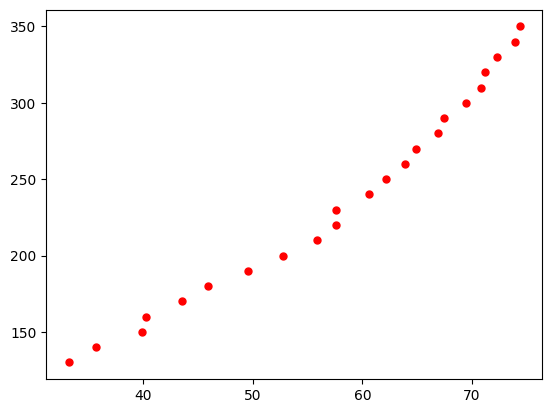

In [2]:
Instance = simulate_instance(n = 50, 
min_arrival = "6:00",
min_availability = "3:00",
max_arrival = "15:00",
min_required_energy = 30,
step = 10,
max_required_energy = 70,
chargers = [20,40,50,50,40,20,30,20,40,50,50,40,20,30],
gamma = 5)



result = MOCS(Instance, population_size = 200, generations = 200, perc_abandoned = 0.2, perc_ev = 0.25, pc = 0.1)
pov = result['objectives_values_pareto_front']
plt.figure()
plt.scatter(pov[:,0], pov[:,1], s=25, c = "red")
plt.show()

# MOCS-GRN

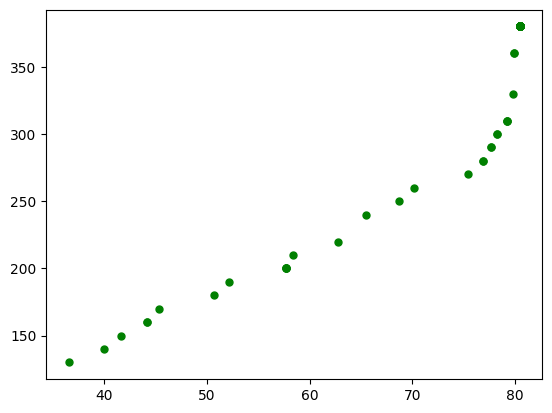

In [3]:
Instance = simulate_instance(n = 50, 
min_arrival = "6:00",
min_availability = "3:00",
max_arrival = "15:00",
min_required_energy = 30,
step = 10,
max_required_energy = 70,
chargers = [20,40,50,50,40,20,30,20,40,50,50,40,20,30],
gamma = 5)


result = MOCS_GRN(Instance, population_size = 200, generations = 200, perc_abandoned = 0.2, perc_ev = 0.25, pc = 0.1, pm1 = 0.2, pm2 = 0.05, perc_genetic_replaced = 0.25)
pov = result['objectives_values_pareto_front']
plt.figure()
plt.scatter(pov[:,0], pov[:,1], s=25, c = "green")
plt.show()

# Single run comparaison between methods

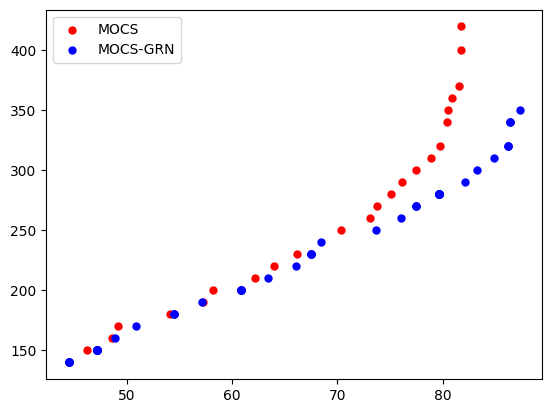

In [5]:
Instance = simulate_instance(n = 50, 
min_arrival = "00:00",
min_availability = "2:00",
max_arrival = "23:59",
min_required_energy = 30,
step = 20,
max_required_energy = 200,
chargers = [20 for _ in range(20)]+[30 for _ in range(20)]+[40 for _ in range(20)]+[50 for _ in range(20)],
gamma = 10)


plt.figure()
result = MOCS(Instance, population_size = 200, generations = 100, perc_abandoned = 0.25, perc_ev = 0.1, pc = 0.05)
pov = result['objectives_values_pareto_front']
plt.scatter(pov[:,0], pov[:,1], s=25, c = "red", label = "MOCS")


result = MOCS_GRN(Instance, population_size = 200, generations = 100, perc_abandoned = 0.25, perc_ev = 0.1, pc = 0.05, pm1 = 0.2, pm2 = 0.05, perc_genetic_replaced = 1)
pov = result['objectives_values_pareto_front']
plt.scatter(pov[:,0], pov[:,1], s=25, c = "blue", label = "MOCS-GRN")

plt.legend()
plt.show()

In [ ]:
Instance = simulate_instance(n = 10, 
min_arrival = "00:00",
min_availability = "3:00",
max_arrival = "23:59",
min_required_energy = 30,
step = 10,
max_required_energy = 70,
chargers = [20,40,50,50,40,20,30,20,40,50,50,40,20,30],
gamma = 60)


result = MOCS(Instance, population_size = 200, generations = 100, perc_abandoned = 0.2, perc_ev = 0.25, pc = 0.1)

pareto_front = result["pareto_front"]
pov = result['objectives_values_pareto_front']
obj1, obj2 = pov[:,0], pov[:,1]
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
path = os.path.join(os.getcwd(),f"Illustration {current_time}")
os.makedirs(path)
for k,schedule in enumerate(pareto_front):
    figure = plot_schedule(Instance, schedule, figsize = (25,5))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    figure.savefig(os.path.join(path,f"{k+1} {obj1[k], obj2[k]}.svg"), format="svg", bbox_inches="tight", pad_inches=0)
pass